# An Example of Cell Type Annotation using SpatioCell

Raw data was downloaded from https://www.10xgenomics.com/datasets/human-lung-cancer-ffpe-2-standard.

Processed input files were saved in [./data](./data/).

* nuclei_segmentation_results.json: output of SpatioCell nuclei segmentation and classification module
* nuclei_segmentation_types.json: nuclei classification types of SpatioCell
* type_mapping.json: a mapping from H&E-based nuclei classification types to deconvolution types, saved in json format
* deconvolution_results.csv: deconvolution results, a table containing cell abundance in each spot, with spot barcodes in rows and cell types in columns
* tissue_positions.csv, scalefactors_json.json: outputs of CellRanger, containing spot position and scale factors of images
* image.tif: full resolution image of H&E stained slide, used for nuclei segmentation and classification, and visualization of cell type annotation results

Data path and other configs should be set in [./configs.yaml](./configs.yaml)

## Run Cell Type Assignment

In [1]:
from celltype_assign import CelltypeAssign
from celltype_assign.set_config import CelltypeAssignConfig

import yaml

In [2]:
# setup an assigner
config_yaml_file = './configs.yaml'

with open('./configs.yaml', 'r') as f:
    configs_data = yaml.safe_load(f)
configs = CelltypeAssignConfig(**configs_data)
assigner = CelltypeAssign(configs)

In [3]:
assigner.preprocess()

Loading data...
Creating cell info...
    Number of nuclei segmented: 288800
    Number of each nuclei type: {'Conn': 137920, 'Inflam': 30652, 'Neo': 117770, 'Epi': 2386, 'Dead': 72}
Defining spatial intervals...
Creating spatial info, using 10 cores...
    Mapping cells into space...
Processing cell composition...
Ready to assign cell types!


In [4]:
assigner.celltype_assign()

Assigning cell types...
    Processing spots, using 10 cores...
    Processing intervals, using 10 cores...
Cell types assigned!


The output files were saved in [./outs](./outs/), including:
* cell_info.json: a dict, containing the annotation of each cell

    for example:

    ```json
    {"1011": {"centroid": [2610.950248756219, 8366.746268656716], "type_prob": [0.04357193782925606, 0.0001967286953004077, 0.0009412876679562032, 0.9548664689064026, 9.909844811772928e-05, 0.0003244538092985749], "type": "Conn", "assign": "Cancer cell", "random_guess": "Plasma cell", "gt": "unassigned type"}}
    ```

    Keys in the dict indicate:

    * "centroid": centroid of the cell
    * "type_prob": softmax scores of H&E-based cell types
    * "type": H&E-based cell type annotation
    * **"assign": cell type annotation using SpatioCell**
    * "random_guess": deconvolution-based cell type annotation
    
* spatial_info.json: a dict, containing cell ids and centroids in each spot and spot interval,
    
    for example:
  
    ```json
    {"GGCATCGAACCTCATA-1": {"cell_id": ["291073","291084"], "centroid": [[26711.2625698324, 9832.994413407821], [26712.74770642202, 9804.660550458715]]}}
    ```

## View Results

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import json
from pathlib import Path

In [6]:
image_file = './data/image.tif'
nuclei_seg_json_file = './data/nuclei_segmentation_results.json'
cell_info_json_file = './results/cell_info.json'

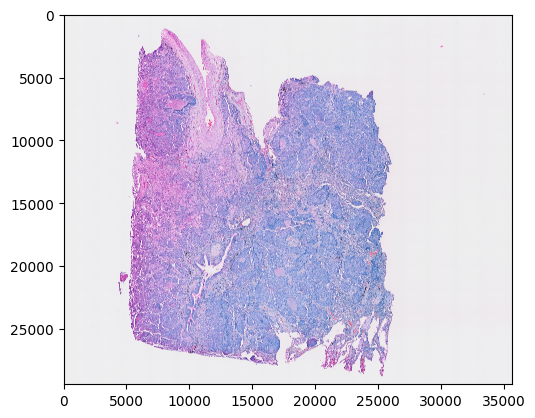

In [7]:
# cv2
image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
with open(nuclei_seg_json_file, 'r') as f:
    nuclei_seg = json.load(f)
with open(cell_info_json_file, 'r') as f:
    cell_info = json.load(f)

plt.imshow(image)
plt.show()

100%|██████████| 14/14 [00:14<00:00,  1.03s/it]


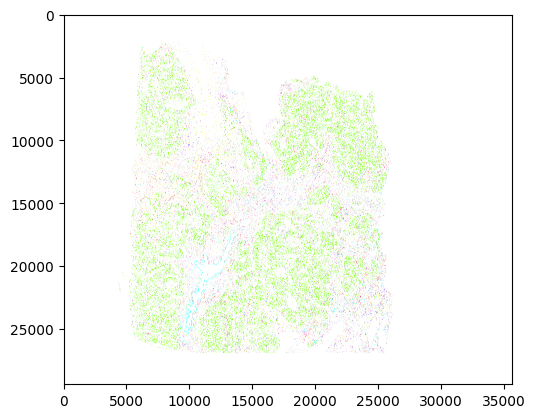

In [8]:
mask_assigned = np.full(image.shape, 255, dtype=np.uint8)
mask_guessed = np.full(image.shape, 255, dtype=np.uint8)
mask_alpha = np.full(image.shape[: 2], 0, dtype=np.uint8)

assigned_color = {
    "B cell": (255, 82, 82),
    "Plasma cell": (255, 128, 171),
    "T cell": (224, 64, 251),
    "NK cell": (255, 171, 64),
    "Mast cell": (255, 64, 129),
    "Macrophage/Monocyte": (197, 17, 98),
    'Neutrophil': (170, 0, 255),
    "DC": (83, 109, 254),
    "Endothelial cell": (124, 77, 255),
    "Epithelial cell": (24, 255, 255),
    "Cancer cell": (118, 255, 3),
    "Stromal": (255, 255, 0),
    "unassigned type": (169, 169, 169),
    "Dead": (169, 169, 169),
}

line_width = -1

for minor_type in tqdm(assigned_color.keys()):
    assigned_contours = [np.array(nuclei_seg['nuc'][i]['contour']) for i in cell_info.keys() if cell_info[i]['assign'] == minor_type]
    guessed_contours = [np.array(nuclei_seg['nuc'][i]['contour']) for i in cell_info.keys() if cell_info[i]['random_guess'] == minor_type]

    cv2.drawContours(mask_assigned, assigned_contours, -1, assigned_color[minor_type], line_width)
    cv2.drawContours(mask_guessed, guessed_contours, -1, assigned_color[minor_type], line_width)
    cv2.drawContours(mask_alpha, assigned_contours, -1, 255, line_width)

mask_assigned = cv2.cvtColor(mask_assigned, cv2.COLOR_RGB2RGBA)
mask_guessed = cv2.cvtColor(mask_guessed, cv2.COLOR_RGB2RGBA)
mask_assigned[..., 3] = mask_alpha
mask_guessed[..., 3] = mask_alpha

plt.imshow(mask_assigned)
plt.show()

Save the images in [./outs/view](./outs/view/)

In [9]:
save_dir = './results/view/'

# resize the images to 1/4 of the original size
image_resized = cv2.resize(image, fx=0.25, fy=0.25, dsize=(0, 0))
mask_assigned_resized = cv2.resize(mask_assigned, fx=0.25, fy=0.25, dsize=(0, 0))
mask_guessed_resized = cv2.resize(mask_guessed, fx=0.25, fy=0.25, dsize=(0, 0))

Path(save_dir).mkdir(parents=True, exist_ok=True)
cv2.imwrite('%s/image_resized.png' % save_dir, cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR))
cv2.imwrite('%s/assigned_mask_resized.png' % save_dir, cv2.cvtColor(mask_assigned_resized, cv2.COLOR_RGBA2BGRA))
cv2.imwrite('%s/guessed_mask_resized.png' % save_dir, cv2.cvtColor(mask_guessed_resized, cv2.COLOR_RGBA2BGRA))

True